In [1]:
import pandas as pd
df = pd.read_csv('Consumer_Complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217.0
1,10/01/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/05/2016,Closed with explanation,Yes,No,2141773.0
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100.0
3,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06/10/2014,Closed with explanation,Yes,Yes,885638.0
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760.0


In [2]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4569 entries, 1 to 21662
Data columns (total 18 columns):
Date received                   4569 non-null object
Product                         4569 non-null object
Sub-product                     3106 non-null object
Issue                           4569 non-null object
Sub-issue                       2294 non-null object
Consumer complaint narrative    4569 non-null object
Company public response         2220 non-null object
Company                         4569 non-null object
State                           4556 non-null object
ZIP code                        4556 non-null object
Tags                            770 non-null object
Consumer consent provided?      4569 non-null object
Submitted via                   4569 non-null object
Date sent to company            4569 non-null object
Company response to consumer    4569 non-null object
Timely response?                4569 non-null object
Consumer disputed?              4568 non-null

In [4]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [5]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [6]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [7]:
df['category_id'] = df['Product'].factorize()[0]
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [8]:
df.head()

,Product,Consumer_complaint_narrative,category_id
1,Credit reporting,I have outdated information on my credit repor...,0
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...,1
7,Credit reporting,An account on my credit report has a mistaken ...,0
12,Debt collection,This company refuses to provide me verificatio...,2
16,Debt collection,This complaint is in regards to Square Two Fin...,2


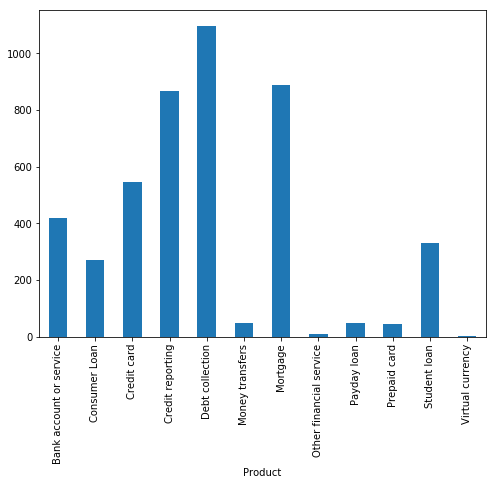

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(4569, 12633)

In [11]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
       . bank
       . overdraft
  . Most correlated bigrams:
       . overdraft fees
       . checking account
# 'Consumer Loan':
  . Most correlated unigrams:
       . car
       . vehicle
  . Most correlated bigrams:
       . vehicle xxxx
       . toyota financial
# 'Credit card':
  . Most correlated unigrams:
       . citi
       . card
  . Most correlated bigrams:
       . annual fee
       . credit card
# 'Credit reporting':
  . Most correlated unigrams:
       . experian
       . equifax
  . Most correlated bigrams:
       . trans union
       . credit report
# 'Debt collection':
  . Most correlated unigrams:
       . collection
       . debt
  . Most correlated bigrams:
       . collect debt
       . collection agency
# 'Money transfers':
  . Most correlated unigrams:
       . wu
       . paypal
  . Most correlated bigrams:
       . western union
       . money transfer
# 'Mortgage':
  . Most correlated unigrams:
      

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [13]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [14]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting']


In [15]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,Product,Consumer_complaint_narrative,category_id
12,Debt collection,This company refuses to provide me verificatio...,2


In [16]:
df[df['Consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

,Product,Consumer_complaint_narrative,category_id
61,Credit reporting,I am disputing the inaccurate information the ...,0


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.

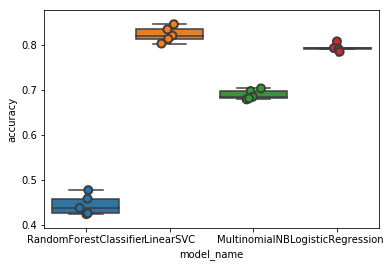

In [18]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [19]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.822890
LogisticRegression        0.792927
MultinomialNB             0.688519
RandomForestClassifier    0.443826
Name: accuracy, dtype: float64

In [20]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

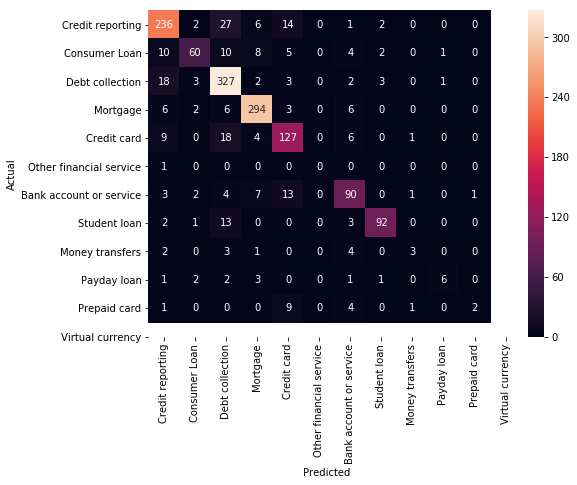

In [21]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [22]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'Consumer Loan' predicted as 'Credit reporting' : 10 examples.


,Product,Consumer_complaint_narrative
2720,Consumer Loan,"Quoting them, your first loan application, the..."
7091,Consumer Loan,"While reviewing my XXXX credit report, I notic..."
5439,Consumer Loan,I have been recently checking my credit report...
12763,Consumer Loan,"We went to buy XXXX cars, and the dealership s..."
13158,Consumer Loan,I got a 30 day late XX/XX/2017 and it 's repor...
4134,Consumer Loan,I took out an instalment loan in the amount XX...
13848,Consumer Loan,I was turned down for a loan by Honda Finacial...
19227,Consumer Loan,"ONEMAIN # XXXX XXXX , IN XXXX ( XXXX ) XXXX Da..."
11258,Consumer Loan,I have not been given credit for the payments ...
11242,Consumer Loan,Reliable Credit falsely submitted an applicati...



'Debt collection' predicted as 'Credit reporting' : 18 examples.


,Product,Consumer_complaint_narrative
18410,Debt collection,"Dear CFPB, I am asking you for assistance to i..."
5262,Debt collection,"XXXX XXXX, XXXX ( This letter describes in det..."
11834,Debt collection,XXXX XXXX XXXX is reporting negatively on my c...
19652,Debt collection,I recently paid of both debts on my credit acc...
15557,Debt collection,Never have been a XXXX XXXX customer. I was at...
4431,Debt collection,someone tried getting credit information and i...
15949,Debt collection,This debt is from account from $ XX/XX/2008 an...
12475,Debt collection,"In XXXX XXXX, there was an account opened thro..."
13548,Debt collection,DIVERSIFIELD CONSULTANTS INC HAVE VIOLATED FCR...
6988,Debt collection,Also collections refuses to stop reporting to ...



'Mortgage' predicted as 'Credit reporting' : 6 examples.


,Product,Consumer_complaint_narrative
4637,Mortgage,This complaint is in follow-up to Complaint # ...
5269,Mortgage,The attached complaint was initially written t...
7343,Mortgage,"In 2014, I went to XXXX in order to buy a mobi..."
15048,Mortgage,Company repeatedly corrects my credit report a...
861,Mortgage,Mortgage broker did Credit inquiry on my credi...
19781,Mortgage,I am a card carrying XXXX and wanted to see if...



'Credit card' predicted as 'Credit reporting' : 9 examples.


,Product,Consumer_complaint_narrative
18643,Credit card,I was told this account wiuld be deleted from ...
18574,Credit card,This inquiry was n't me
19868,Credit card,Capital One/Kohls has been reporting a past du...
19963,Credit card,on XX/XX/XXXX my wallet was stolen with all my...
4706,Credit card,American Express is reporting an account on my...
21566,Credit card,Have disputed the reporting of the status of a...
13906,Credit card,I have been the victim of identity theft fraud...
16853,Credit card,I have requested XXXX XXXX to run a credit rep...
10505,Credit card,I have been working since XXXX 2016 to get a i...


IndexError: index 11 is out of bounds for axis 0 with size 11

In [23]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [24]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . account
  . Top bigrams:
       . debit card
       . overdraft fees
# 'Consumer Loan':
  . Top unigrams:
       . vehicle
       . car
  . Top bigrams:
       . personal loan
       . history xxxx
# 'Credit card':
  . Top unigrams:
       . card
       . discover
  . Top bigrams:
       . credit card
       . discover card
# 'Credit reporting':
  . Top unigrams:
       . equifax
       . transunion
  . Top bigrams:
       . xxxx account
       . trans union
# 'Debt collection':
  . Top unigrams:
       . debt
       . collection
  . Top bigrams:
       . account credit
       . time provided
# 'Money transfers':
  . Top unigrams:
       . paypal
       . transfer
  . Top bigrams:
       . money transfer
       . send money
# 'Mortgage':
  . Top unigrams:
       . mortgage
       . escrow
  . Top bigrams:
       . loan modification
       . mortgage company
# 'Other financial service':
  . Top unigrams:
       . pass

In [29]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Mortgage'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Credit reporting'

"I can't get the money out of the country."
  - Predicted as: 'Bank account or service'

"I have no money to pay my tuition"
  - Predicted as: 'Debt collection'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Bank account or service'



In [30]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Product'].unique()))

                         precision    recall  f1-score   support

       Credit reporting       0.82      0.82      0.82       288
          Consumer Loan       0.83      0.60      0.70       100
        Debt collection       0.80      0.91      0.85       359
               Mortgage       0.90      0.93      0.92       317
            Credit card       0.73      0.77      0.75       165
Other financial service       0.00      0.00      0.00         1
Bank account or service       0.74      0.74      0.74       121
           Student loan       0.92      0.83      0.87       111
        Money transfers       0.50      0.23      0.32        13
            Payday loan       0.75      0.38      0.50        16
           Prepaid card       0.67      0.12      0.20        17

            avg / total       0.82      0.82      0.81      1508



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
